In [1]:
"""
Purpose: 
To develop the code that will from a mesh limb extract the

1) skeleton (and branch decomposition)
2) mesh correspondence for each branch
3) width for each branch



"""

'\nPurpose: \nTo develop the code that will from a mesh limb extract the\n\n1) skeleton (and branch decomposition)\n2) mesh correspondence for each branch\n3) width for each branch\n\n\n\n'

In [2]:
from os import sys
sys.path.append("../../meshAfterParty/")
from importlib import reload
import os
from pathlib import Path
import time

In [3]:
import neuron_utils as nru
nru = reload(nru)
import neuron
neuron=reload(neuron)

import system_utils as su
import numpy as np

In [4]:
import pyembree

# Getting the Neuron to Process

In [5]:
compressed_neuron_path = Path("../test_neurons/test_objects/12345_2_soma_practice_decompress")


with su.suppress_stdout_stderr():
    recovered_neuron = nru.decompress_neuron(filepath=compressed_neuron_path,
                      original_mesh=compressed_neuron_path)

recovered_neuron

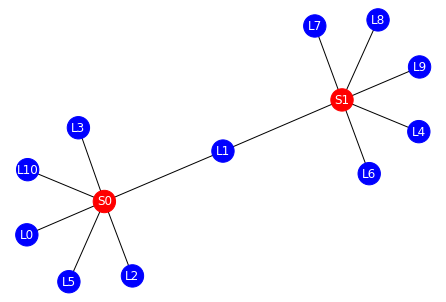

In [6]:
recovered_neuron.plot_soma_limb_concept_network()

In [25]:
import skeleton_utils as sk
limb_name = "L2"
current_soma = "S0"
limb_obj = recovered_neuron.concept_network.nodes[limb_name]["data"]
sk.graph_skeleton_and_mesh(other_meshes=[limb_obj.mesh])

# Running the Meshparty algorithm

# -- Step 0: Getting the skeleton -- 

In [26]:
# Getting a root point
import trimesh_utils as tu



touching_limb,touching_vertices = tu.mesh_pieces_connectivity(recovered_neuron.mesh,
                                                               recovered_neuron.concept_network.nodes[current_soma]["data"].mesh,
                                                               [limb_obj.mesh],
                                                              return_vertices=True
                                                              )
root = touching_vertices[0][0]
root

TrackedArray([757964.8, 960165. , 866226.1])

# Manually setting the root

In [27]:
root = np.array([865523.6, 999041.2, 866004.2])

In [28]:
# How to get the skeleton using just the root
from meshparty import trimesh_io

limb_obj_tr_io  = trimesh_io.Mesh(vertices = limb_obj.mesh.vertices,
                                       faces = limb_obj.mesh.faces,
                                       normals=limb_obj.mesh.face_normals)

In [29]:
from importlib import reload
import meshparty_skeletonize as m_sk
m_sk = reload(m_sk)

skeletonize_time = time.time()

sk_meshparty_obj, v = m_sk.skeletonize_mesh(limb_obj_tr_io,
                      soma_pt = root,
                      soma_radius = 0,
                      collapse_soma = False,
                      invalidation_d=12000,
                      smooth_vertices=True,
                       smooth_neighborhood = 1,
                      compute_radius = True, #Need the pyembree list
                      compute_original_index=True,
                      verbose=True)
print(f"Total time for meshParty skeletonization = {time.time() - skeletonize_time}")

sk_meshparty = sk_meshparty_obj.vertices[sk_meshparty_obj.edges]

  0%|          | 0/56971 [00:00<?, ?it/s]

smooth_neighborhood = 1
smooth_neighborhood = 1



100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Total time for meshParty skeletonization = 1.4677691459655762


# --- Step 1: Decompose the Branches ---- 

In [30]:
segments, segment_maps = m_sk.compute_segments(sk_meshparty_obj)

In [31]:
# getting the skeletons that go with them
segment_branches = [sk_meshparty_obj.vertices[np.vstack([k[:-1],k[1:]]).T] for k in segments]

In [34]:
for i,b in enumerate(segment_branches):
    print(f"\n ----- Branch {i} ----------")
    print(b.shape)


 ----- Branch 0 ----------
(160, 2, 3)

 ----- Branch 1 ----------
(162, 2, 3)

 ----- Branch 2 ----------
(127, 2, 3)

 ----- Branch 3 ----------
(207, 2, 3)

 ----- Branch 4 ----------
(7, 2, 3)

 ----- Branch 5 ----------
(8, 2, 3)

 ----- Branch 6 ----------
(337, 2, 3)

 ----- Branch 7 ----------
(76, 2, 3)

 ----- Branch 8 ----------
(13, 2, 3)

 ----- Branch 9 ----------
(3, 2, 3)

 ----- Branch 10 ----------
(74, 2, 3)

 ----- Branch 11 ----------
(54, 2, 3)

 ----- Branch 12 ----------
(2, 2, 3)

 ----- Branch 13 ----------
(5, 2, 3)

 ----- Branch 14 ----------
(19, 2, 3)

 ----- Branch 15 ----------
(14, 2, 3)

 ----- Branch 16 ----------
(91, 2, 3)

 ----- Branch 17 ----------
(79, 2, 3)

 ----- Branch 18 ----------
(40, 2, 3)

 ----- Branch 19 ----------
(120, 2, 3)

 ----- Branch 20 ----------
(14, 2, 3)

 ----- Branch 21 ----------
(89, 2, 3)

 ----- Branch 22 ----------
(40, 2, 3)

 ----- Branch 23 ----------
(4, 2, 3)

 ----- Branch 24 ----------
(155, 2, 3)

 ----- B

# -- Step 2: Creating the mesh correspondence -- 

In [13]:
import general_utils as gu
gu = reload(gu)

sk_vertices_to_mesh_vertices = gu.invert_mapping(sk_meshparty_obj.mesh_to_skel_map)
#getting a list of all the original vertices that belong to each segment
segment_mesh_vertices = [np.unique(np.concatenate([sk_vertices_to_mesh_vertices[k] for k in segment_list])) for segment_list in segments]
#getting a list of all the original vertices that belong to each segment
segment_mesh_faces = [np.unique(limb_obj.mesh.vertex_faces[k]) for k in segment_mesh_vertices]
segment_mesh_faces = [k[k>=0] for k in segment_mesh_faces]

face_lookup = gu.invert_mapping(segment_mesh_faces)

In [14]:
import itertools 
curr_limb_mesh = limb_obj.mesh

import compartment_utils as cu
cu = reload(cu)

original_labels = set(list(itertools.chain.from_iterable(list(face_lookup.values()))))
print(f"max(original_labels),len(original_labels) = {(max(original_labels),len(original_labels))}")

face_coloring_copy = cu.resolve_empty_conflicting_face_labels(curr_limb_mesh = curr_limb_mesh,
                                                            face_lookup=face_lookup,
                                                            no_missing_labels = list(original_labels))


# -- splitting the mesh pieces into individual pieces
divided_submeshes,divided_submeshes_idx = tu.split_mesh_into_face_groups(curr_limb_mesh,face_coloring_copy)

max(original_labels),len(original_labels) = (46, 47)
empty_indices % = 0.0
 conflict_indices % = 0.018374305622171256


In [15]:
divided_submeshes

{0: <trimesh.Trimesh(vertices.shape=(1208, 3), faces.shape=(2416, 3))>,
 1: <trimesh.Trimesh(vertices.shape=(64, 3), faces.shape=(91, 3))>,
 2: <trimesh.Trimesh(vertices.shape=(65, 3), faces.shape=(109, 3))>,
 3: <trimesh.Trimesh(vertices.shape=(8916, 3), faces.shape=(17923, 3))>,
 4: <trimesh.Trimesh(vertices.shape=(1851, 3), faces.shape=(3667, 3))>,
 5: <trimesh.Trimesh(vertices.shape=(187, 3), faces.shape=(310, 3))>,
 6: <trimesh.Trimesh(vertices.shape=(28, 3), faces.shape=(28, 3))>,
 7: <trimesh.Trimesh(vertices.shape=(2309, 3), faces.shape=(4514, 3))>,
 8: <trimesh.Trimesh(vertices.shape=(5009, 3), faces.shape=(9892, 3))>,
 9: <trimesh.Trimesh(vertices.shape=(442, 3), faces.shape=(817, 3))>,
 10: <trimesh.Trimesh(vertices.shape=(67, 3), faces.shape=(109, 3))>,
 11: <trimesh.Trimesh(vertices.shape=(51, 3), faces.shape=(62, 3))>,
 12: <trimesh.Trimesh(vertices.shape=(604, 3), faces.shape=(1135, 3))>,
 13: <trimesh.Trimesh(vertices.shape=(229, 3), faces.shape=(409, 3))>,
 14: <trimes

# -- Step 3: Getting the Widths ---

In [16]:
segment_width_measurements = [sk_meshparty_obj.vertex_properties["rs"][k] for k in segments]
segment_widths_median = [np.median(k) for k in segment_width_measurements]
len(segment_widths_median)

47

# -- Step 3b: Getting the Other widths -- 

In [17]:
import trimesh_utils as tu
tu = reload(tu)
from tqdm import tqdm
limb_obj_sdf_faces = tu.ray_trace_distance(mesh=limb_obj.mesh, 
                    face_inds=np.arange(0,len(limb_obj.mesh.faces)), 
                   vertex_inds=None,
                   ray_origins=None,
                   ray_directions=None,
                   max_iter=100, 
                   rand_jitter=0.001, 
                   verbose=True,
                   ray_inter=None)

unique_labels = np.sort(np.unique(face_coloring_copy))
branch_widths_mean = dict()
branch_widths_median = dict()
for lab in tqdm(unique_labels):
    faces = np.where(face_coloring_copy==lab)[0]
    face_widths = limb_obj_sdf_faces[faces]
    face_widths = face_widths[face_widths>0]
    branch_widths_mean[lab] = np.mean(face_widths)
    branch_widths_median[lab] = np.median(face_widths)

100%|██████████| 47/47 [00:00<00:00, 5000.18it/s]


# The Final Products

In [19]:
#skeleton branches
segment_branches 
#mesh correspondence (mesh and indices)
divided_submeshes, divided_submeshes_idx
#widths
segment_widths_median

[164.49574601169257,
 458.581919512863,
 240.8000757144417,
 769.0663742650504,
 875.4175647019895,
 991.7446635894662,
 871.8950957673337,
 1100.070416734582,
 1308.5001251210292,
 149.46503922316953,
 396.66519324086454,
 947.5951857799714,
 620.8970732584819,
 458.3592465460267,
 172.40791331220237,
 151.7071772878108,
 283.67777108564917,
 553.5297899129439,
 473.09572541225884,
 549.669936009429,
 232.9823950293637,
 470.90576454342283,
 138.80164444552838,
 176.90600911893756,
 273.9159570197819,
 331.47780695467134,
 536.2718321970683,
 122.62797239512312,
 650.4771253075037,
 928.0085766310342,
 131.85889550966823,
 176.62217544482195,
 534.8227617225668,
 174.49878147042347,
 300.781768596266,
 245.82179774192306,
 143.07709183702852,
 143.14379598055177,
 130.54459344932374,
 553.3023091358436,
 631.2640300857844,
 153.72135978725254,
 403.99530733183144,
 324.9308480156236,
 148.83281394918893,
 132.74431980226728,
 343.240132245462]

In [20]:
segment_branches

[array([[[ 855337.13549319, 1000369.73668435,  808597.14492982],
         [ 855329.27954682, 1000356.92584186,  808582.38686341]],
 
        [[ 855329.27954682, 1000356.92584186,  808582.38686341],
         [ 855306.76540753, 1000319.5438938 ,  808540.156449  ]],
 
        [[ 855306.76540753, 1000319.5438938 ,  808540.156449  ],
         [ 855272.36943806, 1000260.3836201 ,  808476.00486395]],
 
        ...,
 
        [[ 852942.67017477,  973553.50477917,  789979.2688569 ],
         [ 852869.33598471,  973580.0102891 ,  789818.75172121]],
 
        [[ 852869.33598471,  973580.0102891 ,  789818.75172121],
         [ 852785.79985536,  973605.04973643,  789665.67218847]],
 
        [[ 852785.79985536,  973605.04973643,  789665.67218847],
         [ 852699.39624878,  973624.47205862,  789518.28319003]]]),
 array([[[852699.39624878, 973624.47205862, 789518.28319003],
         [852575.5704705 , 973773.8055813 , 789449.3108279 ]],
 
        [[852575.5704705 , 973773.8055813 , 789449.3108279 ]

In [22]:
import skeleton_utils as sk
for i,b in enumerate(segment_branches):
    sk.resize_skeleton_branch(b,n_segments=1)